In [1]:
# %matplotlib inline 


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, preps, strats, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(preps)
importlib.reload(strats)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime, time, timedelta

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])
import torchmetrics

from tqdm.auto import tqdm
from typing import Tuple, Set, List, Union, Dict

import io
from PIL import Image
import IPython.display as disp

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)


Selected checkpoint: trainings/AAPL_0.16750_fin.pth

Hyperparameters:
{'ALPHA_SMOOTH': 0,
 'CLIPNORM': 2,
 'CONV_CHANNELS': 64,
 'CONV_DILATION': 1,
 'CONV_K': 3,
 'DROPOUT_LONG': 0.1,
 'DROPOUT_SHORT': 0.1,
 'DROPOUT_TRANS': 0.03,
 'EARLY_STOP_PATIENCE': 9,
 'FLATTEN_MODE': 'attn',
 'HEAD_LR_PCT': 1,
 'HUBER_DELTA': 0.1,
 'LAMBDA_DELTA': 0.1,
 'LONG_UNITS': 64,
 'LOOK_BACK': 60,
 'MAX_EPOCHS': 90,
 'MICRO_SAMPLE_K': 16,
 'ONECYCLE_DIV_FACTOR': 10,
 'ONECYCLE_FINAL_DIV': 100,
 'ONECYCLE_MAX_LR': 0.0002,
 'ONECYCLE_PCT_START': 0.1,
 'ONECYCLE_STRATEGY': 'cos',
 'PRED_HIDDEN': 96,
 'SHORT_UNITS': 64,
 'TCN_CHANNELS': 64,
 'TCN_KERNEL': 3,
 'TCN_LAYERS': 1,
 'TRAIN_BATCH': 16,
 'TRAIN_PREFETCH_FACTOR': 4,
 'TRAIN_WORKERS': 8,
 'TRANSFORMER_D_MODEL': 64,
 'TRANSFORMER_FF_MULT': 4,
 'TRANSFORMER_HEADS': 4,
 'TRANSFORMER_LAYERS': 2,
 'USE_CONV': False,
 'USE_DELTA': False,
 'USE_HUBER': False,
 'USE_LONG_LSTM': False,
 'USE_SHORT_LSTM': False,
 'USE_TCN': False,
 'USE_TRANSFORMER': True,
 'V

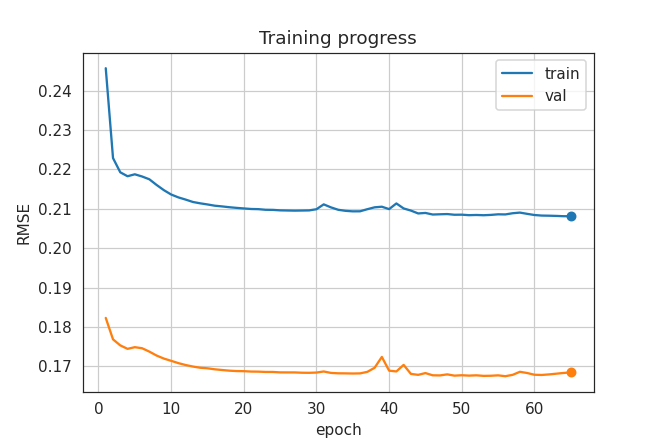


Train metrics: {'rmse': 0.2081150815493038, 'mae': 0.11544631904096875, 'r2': 0.20979207107337317}
 Val metrics: {'rmse': 0.16845990443142478, 'mae': 0.08854206280732163, 'r2': 0.18023783087885004}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (input_proj): Linear(in_features=50, out_features=50, bias=True)
  (feature_proj): Linear(in_features=50, out_features=64, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.03, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.03, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03, inplace=False)
     

In [3]:
fname = f"{params.ticker}_{params.sel_val_rmse}_fin.pth"
model_path = Path(params.models_folder) / fname

print("Selected checkpoint:", model_path)

# Load the on-disk dict (all tensors on CPU, no code executed)
ckpt = torch.load(model_path, map_location="cpu", weights_only=False)

# Inspect metadata, plots, metrics
print("\nHyperparameters:")
pprint(ckpt["hparams"])

model_feats = ckpt['features']
print("\nFeatures:")
print(model_feats)

if "train_plot_png" in ckpt:
    img = Image.open(io.BytesIO(ckpt["train_plot_png"]))
    display(img)

print("\nTrain metrics:", ckpt["train_metrics"])
print(  " Val metrics:", ckpt["val_metrics"])

# Reinstantiate a *clean* model in CPU memory
model_choice = models_custom.ModelClass(
    n_feats             = len(model_feats),
    short_units         = ckpt["hparams"]["SHORT_UNITS"],
    long_units          = ckpt["hparams"]["LONG_UNITS"],
    transformer_d_model = ckpt["hparams"]["TRANSFORMER_D_MODEL"],
    transformer_layers  = ckpt["hparams"]["TRANSFORMER_LAYERS"],
    dropout_short       = ckpt["hparams"]["DROPOUT_SHORT"],
    dropout_long        = ckpt["hparams"]["DROPOUT_LONG"],
    dropout_trans       = ckpt["hparams"]["DROPOUT_TRANS"],
    pred_hidden         = ckpt["hparams"]["PRED_HIDDEN"],
    look_back           = ckpt["hparams"]["LOOK_BACK"],

    # Gating flags
    use_conv            = ckpt["hparams"]["USE_CONV"],
    use_tcn             = ckpt["hparams"]["USE_TCN"],
    use_short_lstm      = ckpt["hparams"]["USE_SHORT_LSTM"],
    use_transformer     = ckpt["hparams"]["USE_TRANSFORMER"],
    use_long_lstm       = ckpt["hparams"]["USE_LONG_LSTM"],
    use_delta           = ckpt["hparams"]["USE_DELTA"],
    flatten_mode        = ckpt["hparams"]["FLATTEN_MODE"]
)

# Load *only* the weight tensors into that fresh model
model_choice.load_state_dict(ckpt["model_state_dict"])
model_choice.to(params.device)
model_choice.eval()

model_choice


In [4]:
cols = params.features_cols_tick + params.signals_cols_tick + [f"{col}_raw" for col in params.strategy_cols_tick]
cols = list(dict.fromkeys(cols))   # remove duplicates, keep order
df_sign_selfeats = pd.read_csv(params.sign_featall_csv, index_col=0, parse_dates=True)[cols]

df_sign_selfeats = df_sign_selfeats[df_sign_selfeats.index.year >= params.init_df_year] ###########
df_sign_selfeats

,atr_pct_7,range_pct,atr_pct_28,ret_std_63,donch_w_20,ret_std_21,atr_pct_14,time_afthour,kc_w_20_20_1.5,bb_w_20_2p0,dist_low_200,time_in_sess,donch_w_55,trade_count,bb_w_50_2p0,lower_shad,time_premark,upper_shad,dist_high_200,time_hour,volume,time_minute,time_week_of_year,sma_pct_200,atr_7_RZ,time_month,atr_14_RZ,time_day_of_year,adx_28,vol_spike_28,sma_pct_50,atr_28_RZ,roc_5,body_pct,plus_di_14,roll_vwap_20_RZ,minus_di_7,plus_di_28,plus_di_7,rolling_max_close_200_RZ,minus_di_28,sma_pct_100,minus_di_14,roc_21,ret,rolling_min_close_200_RZ,rsi_21,ema_8_RZ,vol_spike_14,macd_signal_6_13_5_RZ,close_raw,targ_signal,signal_thresh,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw
2019-01-02 08:00:00,1.000000,1.000000,0.539469,1.000000,1.000000,1.000000,0.964481,0.0,0.695324,1.000000,0.202308,0.0,1.000000,0.008669,0.559765,1.000000,1.0,0.0000,0.831573,0.270833,0.010662,0.270833,0.500000,0.000000,1.000000,0.5,1.000000,0.502740,0.189077,0.824080,0.000000,1.000000,0.000000,0.000000,0.022780,0.000000,1.000000,0.000000,0.032218,0.624997,1.000000,0.000000,1.000000,0.000000,0.000000,0.366896,0.000000,0.000000,0.817293,0.000000,38.500,0.100676,0.121416,0.100663,31.744522,4.083626,38.500000
2019-01-02 08:01:00,1.000000,0.000000,0.519885,1.000000,1.000000,1.000000,0.895243,0.0,0.661687,1.000000,0.202308,0.0,1.000000,0.000255,0.787723,0.000000,1.0,0.0000,0.831573,0.270833,0.000161,0.271528,0.500000,0.000000,1.000000,0.5,1.000000,0.502740,0.231728,0.029487,0.000000,1.000000,0.000000,0.502374,0.022780,0.000000,1.000000,0.000000,0.032218,0.624997,1.000000,0.000000,1.000000,0.000000,0.500539,0.366897,0.000000,0.000000,0.030440,0.000000,38.500,0.121157,0.121416,0.093473,35.997314,4.083626,38.500000
2019-01-02 08:02:00,1.000000,0.009418,0.501454,1.000000,1.000000,1.000000,0.831810,0.0,0.630139,1.000000,0.202308,0.0,1.000000,0.000255,0.957824,0.000000,1.0,0.0000,0.831573,0.270833,0.000324,0.272222,0.500000,0.000000,1.000000,0.5,1.000000,0.502740,0.272747,0.042049,0.000000,1.000000,0.000000,0.492905,0.023995,0.000000,0.999010,0.000000,0.033467,0.624997,1.000000,0.000000,1.000000,0.000000,0.500539,0.366897,0.000000,0.000000,0.046070,0.000000,38.500,0.145805,0.121416,0.086885,39.931785,4.083626,38.500000
2019-01-02 08:03:00,1.000000,0.018836,0.484137,1.000000,1.000000,1.000000,0.773768,0.0,0.600605,1.000000,0.202308,0.0,1.000000,0.000255,1.000000,0.000000,1.0,0.0000,0.831573,0.270833,0.000486,0.272917,0.500000,0.000000,1.000000,0.5,1.000000,0.502740,0.312189,0.054676,0.000000,1.000000,0.000000,0.483437,0.025240,0.000000,0.996104,0.000000,0.034866,0.624997,1.000000,0.000000,1.000000,0.000000,0.500539,0.366898,0.000000,0.000000,0.060949,0.000000,38.500,0.175468,0.121416,0.080858,43.569590,4.083626,38.500000
2019-01-02 08:04:00,0.954582,0.000000,0.466529,1.000000,1.000000,1.000000,0.718153,0.0,0.571183,1.000000,0.202308,0.0,1.000000,0.000255,1.000000,0.000000,1.0,0.0000,0.831573,0.270833,0.001467,0.273611,0.500000,0.000000,1.000000,0.5,1.000000,0.502740,0.350222,0.128669,0.000000,1.000000,0.000000,0.502374,0.025240,0.000000,0.996104,0.000000,0.034866,0.624997,1.000000,0.000000,1.000000,0.000000,0.500539,0.366898,0.000000,0.000000,0.141225,0.000000,38.500,0.211165,0.121416,0.075082,46.947552,4.083626,38.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 17:29:00,0.190067,0.134332,0.202690,0.172218,0.213304,0.173700,0.190330,0.0,0.195248,0.203577,0.285845,1.0,0.121831,0.281999,0.114646,0.207692,0.0,0.2400,0.004729,0.645833,0.054167,0.665972,0.519231,0.641047,0.145232,0.5,0.140438,0.521918,0.113547,0.247562,0.620479,0.150573,0.731854,0.573301,0.407921,0.440373,0.032127,0.360762,0.495497,0.602940,0.171854,0.622654,0.109079,0.666362,0.577876,1.000000,0.681735,0.476832,0.318022,0.543059,259.120,0.000000,0.065794,0.136420,22.081776,88.210255,258.042621
2026-01-

In [5]:
# importlib.reload(params)
# importlib.reload(models_core)

train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df              = df_sign_selfeats,
    train_batch     = params.hparams["TRAIN_BATCH"],
    train_workers   = params.hparams["TRAIN_WORKERS"],
    prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"],
    look_back       = params.hparams["LOOK_BACK"],
    features_cols   = params.features_cols_tick,
)

Preparing days:   0%|          | 0/1766 [00:00<?, ?it/s]

N_total: 1560011 look_back: 60 F: 50
Estimated X_buf size: 18.72 GB — using RAM (in-memory) (thresh 56 GiB)


Writing days:   0%|          | 0/1766 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

In [6]:
# for name, ld, tm in zip(
#     ["train","val","test"],
#     [train_loader, val_loader, test_loader],
#     [end_times_tr, end_times_val, end_times_te]
# ):
#     models_core.summarize_split(name, ld, tm)

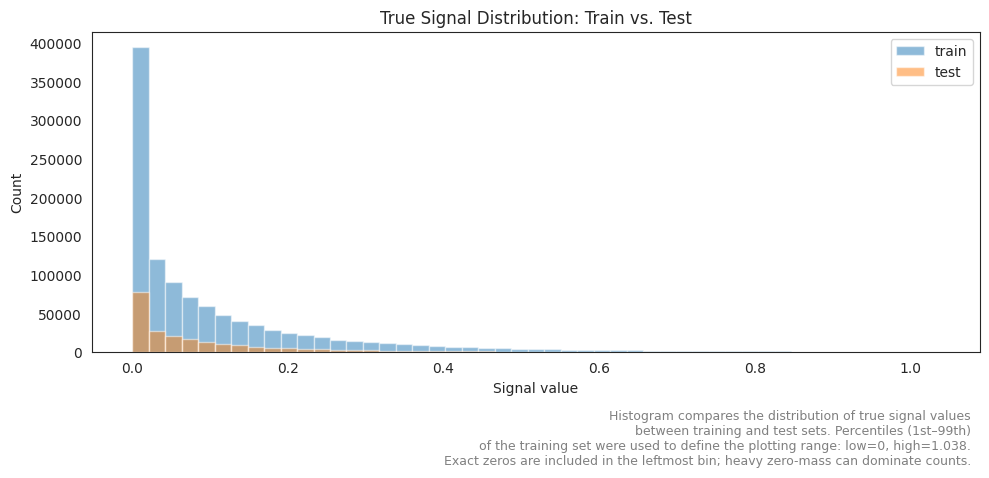

In [7]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_test = np.concatenate([batch[1].cpu().numpy().ravel() for batch in test_loader])

low, high = np.percentile(y_train, [1, 99])
bins = np.linspace(low, high, 50)   # zeros will be included in the leftmost bin if <= low

plt.figure(figsize=(10,5))
plt.hist(y_train, bins=bins, alpha=0.5, label="train")
plt.hist(y_test,   bins=bins, alpha=0.5, label="test")

# description / annotation
desc = (
    "Histogram compares the distribution of true signal values\n"
    "between training and test sets. Percentiles (1st–99th)\n"
    f"of the training set were used to define the plotting range: low={low:.4g}, high={high:.4g}.\n"
    "Exact zeros are included in the leftmost bin; heavy zero-mass can dominate counts."
)
plt.title("True Signal Distribution: Train vs. Test")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.legend()
plt.gca().text(
    0.99, -0.18, desc, ha="right", va="top", transform=plt.gca().transAxes,
    fontsize=9, color="gray"
)
plt.tight_layout()
plt.show()



In [8]:
# importlib.reload(models_custom) ########

print('Calculating Train metrics and predictions...')
train_metrics, _, train_preds, _, _ = \
    models_custom.eval_on_loader(train_loader, model_choice)

print('Calculating Val metrics and predictions...')
val_metrics, _, val_preds, _, _  = \
    models_custom.eval_on_loader(val_loader,   model_choice)

print('Calculating Test metrics and predictions...')
test_metrics, _, test_preds, _, _ = \
    models_custom.eval_on_loader(test_loader,  model_choice)


# Simple summary
print("=== SIMPLE SUMMARY ===\n")

print("Predictions lengths:")
print(f"  Train : {len(train_preds)}")
print(f"  Valid : {len(val_preds)}")
print(f"  Test  : {len(test_preds)}\n")

print("Metrics:")
print(f"  Train → RMSE={train_metrics['rmse']:.5f}, MAE={train_metrics['mae']:.5f}, R²={train_metrics['r2']:.5f}")
print(f"  Valid → RMSE={val_metrics['rmse']:.5f}, MAE={val_metrics['mae']:.5f}, R²={val_metrics['r2']:.5f}")
print(f"  Test  → RMSE={test_metrics['rmse']:.5f}, MAE={test_metrics['mae']:.5f}, R²={test_metrics['r2']:.5f}\n")

print("Predictions stats (mean±std):")
print(f"  Train : {train_preds.mean():.5f} ± {train_preds.std():.5f}")
print(f"  Valid : {val_preds.mean():.5f} ± {val_preds.std():.5f}")
print(f"  Test  : {test_preds.mean():.5f} ± {test_preds.std():.5f}")


Calculating Train metrics and predictions...


eval:   0%|          | 0/78 [00:00<?, ?it/s]

Calculating Val metrics and predictions...


eval:   0%|          | 0/254 [00:00<?, ?it/s]

Calculating Test metrics and predictions...


eval:   0%|          | 0/264 [00:00<?, ?it/s]

=== SIMPLE SUMMARY ===

Predictions lengths:
  Train : 1094984
  Valid : 228366
  Test  : 236661

Metrics:
  Train → RMSE=0.20769, MAE=0.11324, R²=0.21300
  Valid → RMSE=0.16750, MAE=0.09303, R²=0.18957
  Test  → RMSE=0.22468, MAE=0.11268, R²=0.20663

Predictions stats (mean±std):
  Train : 0.12789 ± 0.10426
  Valid : 0.10535 ± 0.08128
  Test  : 0.12683 ± 0.11361


In [9]:
# importlib.reload(models_custom)

# Stamp predictions, then split into train+val & test
df_trainval, df_test = models_custom.add_preds_and_split( 
    df            = df_sign_selfeats,
    train_preds   = train_preds,
    val_preds     = val_preds,
    test_preds    = test_preds,
    end_times_tr  = end_times_tr,
    end_times_val = end_times_val,
    end_times_te  = end_times_te
)

df_test

Stamping train:   0%|          | 0/1094984 [00:00<?, ?ts/s]

Stamping val:   0%|          | 0/228366 [00:00<?, ?ts/s]

Stamping test:   0%|          | 0/236661 [00:00<?, ?ts/s]

,atr_pct_7,range_pct,atr_pct_28,ret_std_63,donch_w_20,ret_std_21,atr_pct_14,time_afthour,kc_w_20_20_1.5,bb_w_20_2p0,dist_low_200,time_in_sess,donch_w_55,trade_count,bb_w_50_2p0,lower_shad,time_premark,upper_shad,dist_high_200,time_hour,volume,time_minute,time_week_of_year,sma_pct_200,atr_7_RZ,time_month,atr_14_RZ,time_day_of_year,adx_28,vol_spike_28,sma_pct_50,atr_28_RZ,roc_5,body_pct,plus_di_14,roll_vwap_20_RZ,minus_di_7,plus_di_28,plus_di_7,rolling_max_close_200_RZ,minus_di_28,sma_pct_100,minus_di_14,roc_21,ret,rolling_min_close_200_RZ,rsi_21,ema_8_RZ,vol_spike_14,macd_signal_6_13_5_RZ,close_raw,targ_signal,signal_thresh,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,pred_signal,ask,bid
2024-12-19 08:59:00,0.034861,0.000000,0.097831,0.254338,0.087599,0.079676,0.064097,0.0,0.081094,0.096925,0.153780,0.0,0.115791,0.003825,0.108968,0.000000,1.0,0.0000,0.045778,0.270833,0.000072,0.311806,0.461538,0.588395,0.063409,0.416667,0.066460,0.467123,0.200200,0.054039,0.500233,0.044661,0.475990,0.502374,0.253521,0.507736,0.439461,0.412590,0.093212,0.60294,0.341734,0.564405,0.340920,0.441601,0.500539,0.366904,0.453979,0.479574,0.061942,0.374419,247.620000,0.004462,0.058706,0.046053,20.928655,12.033127,247.554810,0.071062,247.669524,247.570476
2024-12-19 09:00:00,0.029527,0.000000,0.094019,0.254083,0.054884,0.051621,0.059172,0.0,0.076706,0.081171,0.153780,0.0,0.115791,0.003570,0.103908,0.000000,1.0,0.0000,0.045778,0.312500,0.000000,0.312500,0.461538,0.588136,0.058926,0.416667,0.062843,0.467123,0.195909,0.040607,0.498261,0.041988,0.485034,0.502374,0.253521,0.503586,0.439461,0.412590,0.093212,0.60294,0.341734,0.562921,0.340920,0.409022,0.500539,0.366904,0.453979,0.474417,0.046931,0.378446,247.620000,0.005370,0.058706,0.042763,20.148163,12.033127,247.554992,0.068472,247.669524,247.570476
2024-12-19 09:01:00,0.026975,0.000000,0.090914,0.253990,0.057403,0.051175,0.055671,0.0,0.073308,0.077997,0.152515,0.0,0.115797,0.003697,0.103667,0.000000,1.0,0.0000,0.047018,0.312500,0.000074,0.313194,0.461538,0.586489,0.057640,0.416667,0.061639,0.467123,0.191108,0.057315,0.495163,0.037976,0.488910,0.502374,0.248527,0.501437,0.481407,0.409692,0.086695,0.60294,0.348919,0.559482,0.357363,0.406513,0.488981,0.366904,0.445612,0.470474,0.070498,0.382301,247.610000,0.006685,0.058706,0.040423,19.642782,10.082908,247.555206,0.067240,247.659522,247.560478
2024-12-19 09:02:00,0.024787,0.000000,0.087919,0.254017,0.058664,0.016745,0.052420,0.0,0.070080,0.073188,0.151250,0.0,0.108073,0.003825,0.100342,0.000000,1.0,0.0000,0.048257,0.312500,0.000161,0.313889,0.461538,0.584688,0.056386,0.416667,0.057906,0.467123,0.185804,0.077827,0.490938,0.033236,0.488910,0.502374,0.243343,0.498442,0.523614,0.406722,0.080136,0.60294,0.356285,0.555945,0.374433,0.436581,0.488980,0.366904,0.437062,0.469148,0.097119,0.386534,247.600000,0.008314,0.058706,0.038250,19.393586,8.441218,247.555428,0.065524,247.649520,247.550480
2024-12-19 09:03:00,0.028300,0.007811,0.086550,0.208149,0.066644,0.018627,0.052259,0.0,0.069067,0.070524,0.146611,0.0,0.108091,0.004165,0.099201,0.000000,1.0,0.0000,0.052802,0.312500,0.000158,0.314583,0.461538,0.578918,0.061681,0.416667,0.058478,0.467123,0.178246,0.079770,0.480028,0.047336,0.469955,0.494521,0.224633,0.495603,0.650577,0.395738,0.060409,0.60294,0.383523,0.547205,0.436036,0.427378,0.458155,0.366904,0.406212,0.467418,0.104316,0.388319,247.563333,0.011188,0.058706,0.038137,19.897523,4.917966,247.555467,0.062167,247.612846,247.513821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 17:29:00,0.190067,0.134332,0.202690,0.172218,0.213304,0.173700,0.190330,0.0,0.195248,0.203577,0.285845,1.0,0.121831,0.281999,0.114646,0.207692,0.0,0.2400,0.004729,0.645833,0.054167,0.665972,0.519231,0.641047,0.145232,0.500000,0.140438,0.521918,0.113547,0.247562,0.620479,0.150

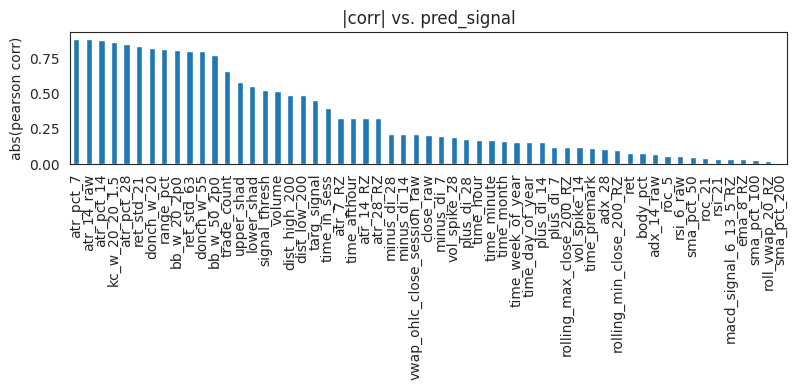

atr_pct_7                      0.891153
atr_14_raw                     0.885293
atr_pct_14                     0.880852
kc_w_20_20_1.5                 0.868123
atr_pct_28                     0.850240
ret_std_21                     0.835958
donch_w_20                     0.827154
range_pct                      0.818252
bb_w_20_2p0                    0.807980
ret_std_63                     0.802904
donch_w_55                     0.801882
bb_w_50_2p0                    0.771746
trade_count                    0.661643
upper_shad                     0.580371
lower_shad                     0.555372
signal_thresh                  0.528080
volume                         0.518163
dist_high_200                  0.489691
dist_low_200                   0.488538
targ_signal                    0.454661
time_in_sess                   0.399059
atr_7_RZ                       0.330578
time_afthour                   0.330059
atr_14_RZ                      0.327623
atr_28_RZ                      0.327465


In [10]:
# Pearson corr between each feature and the pred_signal on the test split

# Identify feature columns (drop non-inputs)
feat_cols = [
    c for c in df_test.columns
    if c not in ("bid","ask", "pred_signal", params.signals_cols_tick)
]

# Compute absolute corr(feature, pred_signal)
corrs = df_test[feat_cols] \
    .corrwith(df_test["pred_signal"]) \
    .abs() \
    .sort_values(ascending=False)

# Bar plot
corrs.plot.bar(figsize=(8,4), title="|corr| vs. pred_signal")
plt.ylabel("abs(pearson corr)")
plt.tight_layout()
plt.show()

corrs

In [11]:
# Descriptive Statistics shows whether the model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

stats = df_test[['targ_signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['targ_signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

,count,mean,std,min,25%,50%,75%,max,range,pearson_r_with_other
targ_signal,236661.0,0.128943,0.252248,0.000000,0.010229,0.054287,0.151290,10.855122,10.855122,0.454661
pred_signal,236661.0,0.126827,0.113610,0.006866,0.057583,0.101263,0.153283,1.445427,1.438562,0.454661


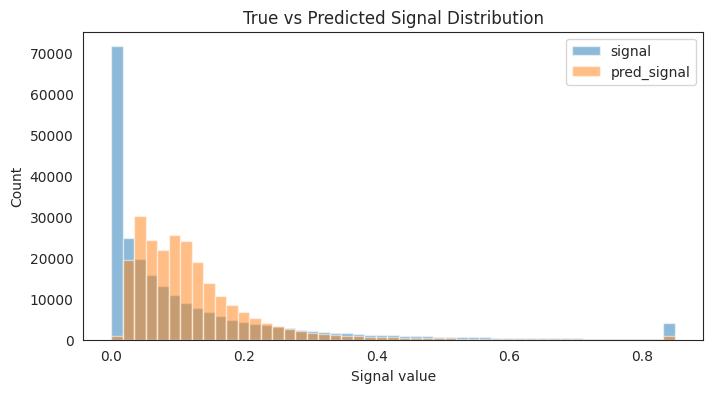

In [12]:
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

a = df_test['targ_signal'].to_numpy(dtype=np.float64)
b = df_test['pred_signal'].to_numpy(dtype=np.float64)
low, high = np.percentile(np.concatenate((a, b)), [1, 99])
bins = np.linspace(low, high, 50)

a_clip = np.clip(a, low, high)
b_clip = np.clip(b, low, high)

plt.figure(figsize=(8,4))
plt.hist(a_clip, bins=bins, alpha=0.5, label='signal')
plt.hist(b_clip, bins=bins, alpha=0.5, label='pred_signal')
plt.title("True vs Predicted Signal Distribution")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.legend()
plt.show()



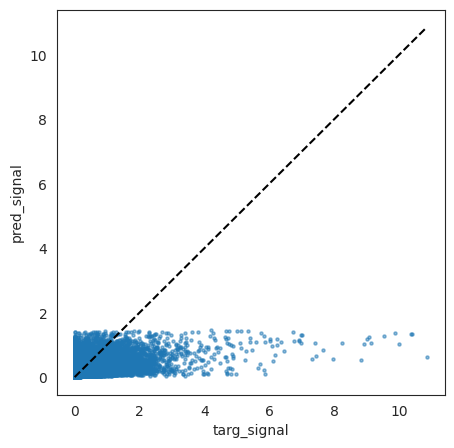

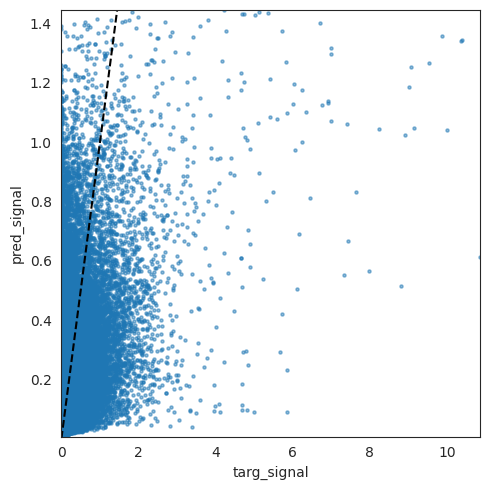

In [13]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

x = df_test['targ_signal'].to_numpy()
y = df_test['pred_signal'].to_numpy()

plt.figure(figsize=(5,5))
plt.scatter(x, y, s=5, alpha=0.5)
mn, mx = min(x.min(), y.min()), max(x.max(), y.max())
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel('targ_signal'); plt.ylabel('pred_signal')
plt.show()


plt.figure(figsize=(5,5))
plt.scatter(x, y, s=5, alpha=0.5)
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
xl = plt.xlim()            # use visible x-limits for the identity line
plt.plot(xl, xl, 'k--')    # 45° reference without changing axes
plt.xlabel('targ_signal'); plt.ylabel('pred_signal')
plt.tight_layout(); plt.show()



Selected day: 2025-04-04


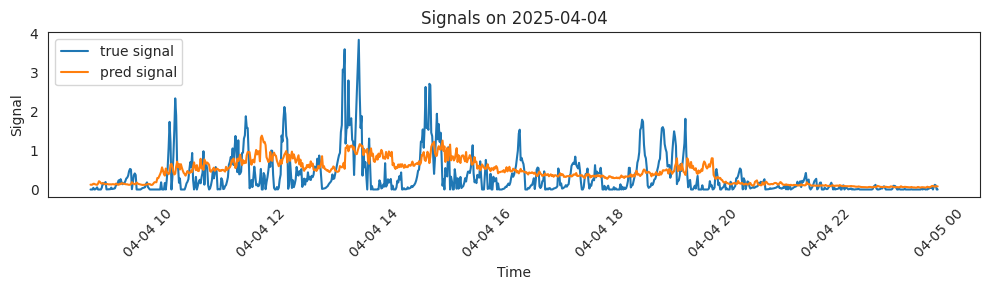

In [14]:
# pick a random day (normalized to midnight)
days = df_test.index.normalize().unique()
random_day = np.random.choice(days)
print("Selected day:", pd.to_datetime(random_day).date())

mask = df_test.index.normalize() == random_day

# Plot true vs. predicted signal on the random day
plt.figure(figsize=(10, 3))
plt.plot(df_test.index[mask], df_test.loc[mask, 'targ_signal'],      label='true signal')
plt.plot(df_test.index[mask], df_test.loc[mask, 'pred_signal'], label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {pd.to_datetime(random_day).date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

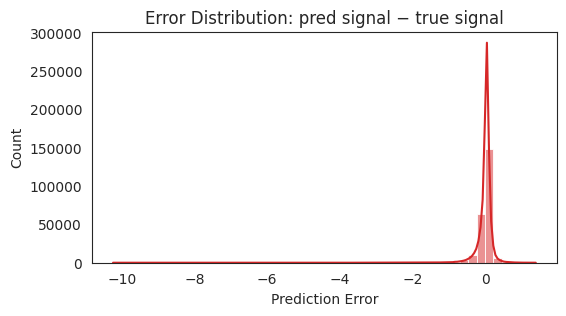

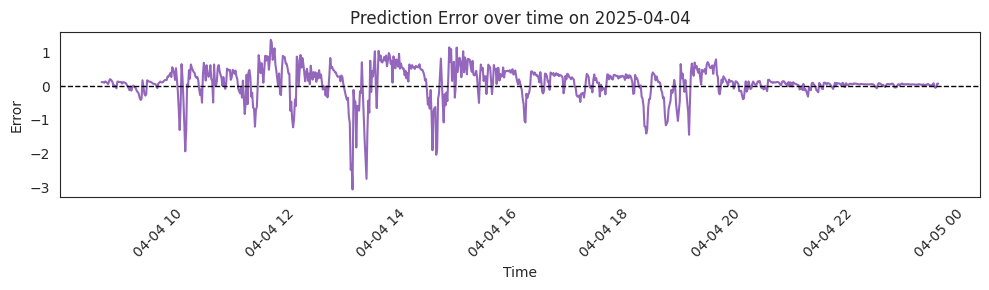

In [15]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding  to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['targ_signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same random day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {pd.to_datetime(random_day).date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
# # importlib.reload(params) ######

# col_signal = 'pred_signal'
# sign_thresh = 'signal_thresh' # to be optimized

# df_sim = df_test # select which environment to simulate

# first_day = df_sim.index.normalize().min()
# start_ask = df_sim.loc[df_sim.index.normalize() == first_day, "ask"].iloc[0]
# strats.reset_globals(start_ask)

# sim_results = {}
# groups = df_sim.groupby(df_sim.index.normalize())
# total_days = df_sim.index.normalize().nunique()


# for day, df_day_sim in tqdm(groups, desc="Generate+Simulate", total=total_days):

#     df_actions = strats.generate_actions_alpaca(
#         df              = df_day_sim,
#         col_signal      = col_signal,
#         sign_thresh     = sign_thresh,
#         col_atr         = 'atr_14_raw',
#         col_adx         = 'adx_14_raw',
#         col_rsi         = 'rsi_6_raw',
#         col_vwap        = 'vwap_ohlc_close_session_raw',
#         col_close       = 'close_raw',
#         reset_peak      = params.reset_peak_tick,
#         rsi_min_thresh  = params.rsi_min_thresh_tick,
#         rsi_max_thresh  = params.rsi_max_thresh_tick,
#         atr_mult        = params.atr_mult_tick,
#         vwap_atr_mult   = params.vwap_atr_mult_tick,
#         adx_thresh      = params.adx_thresh_tick,
#         trailstop_pct   = params.trailstop_pct_tick,
#         sess_start      = params.sess_premark,
#     )
    
#     sim_results.update(
#         strats.simulate_trading(
#             day         = day,
#             df          = df_actions,
#             buy_factor  = params.buy_factor_tick,
#             sell_factor = params.sell_factor_tick,
#         )
#     )

# print("Loop finished. Days simulated:", len(sim_results))


In [17]:
# # importlib.reload(params) ######
# # importlib.reload(strats) ######
# # importlib.reload(plots) ######

# year, month = map(int, params.month_to_check.split("-"))
# dates_in_month = [date for date in sim_results if date.year == year and date.month == month]

# if not dates_in_month:
#     print(f"No simulation data for {params.month_to_check}")
# else:
#     for date in sorted(dates_in_month):
#         df_at_date_plot, trades_at_date, stats_at_date = sim_results[date]
#         plots.plot_trades(
#             df                 = df_at_date_plot,
#             col_signal1        = col_signal,
#             sign_thresh        = sign_thresh, 
#             axis_sig_thresh    = 'second',
#             features           = [params.col_atr_tick, params.col_adx_tick, params.col_rsi_tick, params.col_vwap_tick],
#             autoscale          = False,
#             col_close          = 'close_raw'
#         )
        
#         print(f"\n{' ' * 50}******* Performance for {date.strftime('%Y-%m-%d')} *******\n")
#         for k,v in stats_at_date.items(): # Print stats dict for each date nicely
#             print(f"{k}:\n" + "\n".join("  "+L for L in (v if isinstance(v,list) else str(v).splitlines())))
#         print("\n" + "="*160 + "\n")

# # final visualizations and monthly aggregations
# strats.aggregate_performance(df = df_sim,
#                              sim_results = sim_results)


In [19]:
# 2) Persist CSVs

print("Saving test CSV…")
params.to_csv_with_progress(df_test, params.pred_test_csv)

print("Saving train+val CSV…")
params.to_csv_with_progress(df_trainval, params.pred_trainval_csv)

Saving test CSV…


Saving CSV: 100%|██████████| 236661/236661 [00:56<00:00, 4200.86rows/s, size=232.6MB]


Saving train+val CSV…


Saving CSV: 100%|██████████| 1323350/1323350 [04:47<00:00, 4595.44rows/s, size=1.2GB]   
